In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt
from methods.minimization import DecentralizedGD, LoggerDecentralized, Diging
from oracles.minimization import QuadraticOracle
from oracles.minimization import LinearRegressionL2Oracle
import random

from laplacians import check_laplacian, clique_with_two_similar_edges, big_laplacian, creation, \
    special_supermatrix, usual_laplacian
%matplotlib inline

In [2]:
assert check_laplacian(special_supermatrix(3, 3))
assert check_laplacian(usual_laplacian(3, 3))
assert check_laplacian(clique_with_two_similar_edges(4))

In [3]:
def experiment(n, k, epsilon, max_iter, seed=None, **kwargs):
    data = creation(n, k, n, seed)
    
    W = usual_laplacian(n, k)
    W_super = special_supermatrix(n, k)
    
    mix_mat_1 = np.eye(W.shape[0]) - W / sla.eigvals(W).real.max()
    mix_mat_2 = np.eye(W_super.shape[0]) - W_super / sla.eigvals(W_super).real.max()
    
    oracles = [LinearRegressionL2Oracle(data[m][0], data[m][1], 0) for m in range(k * n)] 
    
    column_A = np.zeros((n**2 * k, n))
    column_b = np.zeros((n**2 * k))
    for i in range(n * k):
        column_A[i * n:(i + 1) * n, :] = data[i][0] 
        column_b[i * n:(i + 1) * n] = data[i][1]
    # np.vstack
    
    x_real = sla.lstsq(column_A, column_b)[0]
    x_0 = np.zeros((k * n * n)).reshape(n * k, n)
    inactive_positions = np.vstack([np.abs(data[i][0]).sum(axis=0) == 0 for i in range(n*k)])
    x_0[inactive_positions] = np.tile(x_real, n*k).reshape(n*k, n)[inactive_positions]
    
    logger_1 = LoggerDecentralized(x_real)
    method_1 = Diging(
        oracle_list=oracles,
        stepsize=kwargs.get('stepsize', 0.0001),
        mix_mat=mix_mat_1,
        x_0=x_0,
        logger=logger_1,
        mix_mat_repr="simple"
    )
    
    logger_2 = LoggerDecentralized(x_real)
    method_2 = Diging(
        oracle_list=oracles,
        stepsize=kwargs.get('stepsize', 0.0001),
        mix_mat=mix_mat_2,
        x_0=x_0,
        logger=logger_2,
        mix_mat_repr="kronecker"
    )   

    method_1.run(max_iter=max_iter)
    method_2.run(max_iter=max_iter)
    
    return {'logger_usual': logger_1, 'logger_super': logger_2, 'func_true': np.mean([oracle.func(x_real) for oracle in oracles])}

In [4]:
%%time
results = experiment(5, 3, 1, 5000, seed=0, stepsize=1e-5)

CPU times: user 3.83 s, sys: 11.6 ms, total: 3.84 s
Wall time: 2.92 s


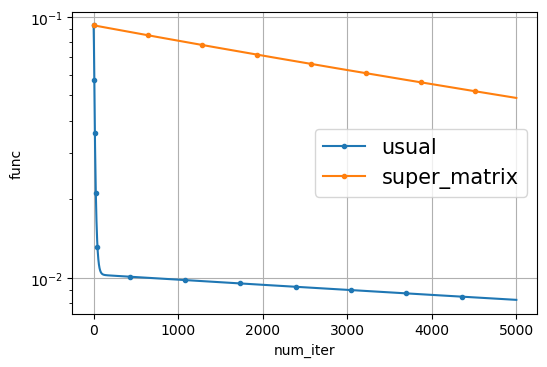

In [5]:
plot_type = "func_avg"

logger_1 = results['logger_usual']
logger_2 = results['logger_super']
func_true = results['func_true']
# func_true = 0

plt.figure(dpi=100)
ax = plt.gca()
if plot_type == "con":
    plot_data_1 = logger_1.sq_dist_to_con
    plot_data_2 = logger_2.sq_dist_to_con
    y_label = "sq_dist_to_con"
elif plot_type == "avg_to_opt":
    plot_data_1 = logger_1.sq_dist_avg_to_opt
    plot_data_2 = logger_2.sq_dist_avg_to_opt
    y_label = "sq_dist_avg_to_opt"
elif plot_type == "func_avg":
    plot_data_1 = np.array(logger_1.func_avg) - func_true
    plot_data_2 = np.array(logger_2.func_avg) - func_true
    y_label = "func"
else:
    raise ValueError("Expected plot_type to be 'con', 'avg_to_opt', 'func_avg', got '{}'".format(plot_type))

owo_1 = [i for i in range(len(plot_data_1))]
owo_2 = [i for i in range(len(plot_data_2))]
ax.plot(owo_1, plot_data_1, '.-', markevery=0.1, label='usual')
ax.plot(owo_2, plot_data_2, '.-', markevery=0.1, label='super_matrix')
ax.set_xlabel('num_iter', fontsize=10)
ax.set_ylabel(y_label, fontsize=10)
ax.set_yscale('log')
ax.grid()
ax.legend(fontsize=15)